# 1. 모듈 로딩

In [ ]:
# module import
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tensorflow.keras.preprocessing import image
from tensorflow.keras import (Input, Model, layers, losses, optimizers, metrics, utils, models)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 2. 데이터 불러오기

In [ ]:
# Kaggle dataset 다운로드
os.environ['KAGGLE_CONFIG_DIR'] = "/content" 
!kaggle datasets download -d gpiosenka/sports-classification

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# dataset 압축해제
!unzip sports-classification.zip

# path 지정
from pathlib import Path
train_path = Path("/content/train")
train_path.glob(r'**/*.jpg')

val_path = Path("/content/valid")
val_path.glob(r'**/*.jpg')

test_path = Path("/content/test")
test_path.glob(r'**/*.jpg')

# 3. 파라미터 지정

In [ ]:
# 파라미터 설정
image_size = (224, 224)
image_shape = (224, 224, 3)
num_classes = len(os.listdir(test_path))
batch = 100
epoch = 30
learning_rate = 0.001

### 4. 이미지 제너레이터

In [ ]:
# 이미지 생성기 객체 생성
data_generator = image.ImageDataGenerator(rescale = 1./255)

# 훈련셋이미지 생성
train_generator = data_generator.flow_from_directory(directory= train_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch)

# 검증셋이미지 생성
val_generator = data_generator.flow_from_directory(directory= val_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch)

# 평가셋이미지 생성
test_generator = data_generator.flow_from_directory(directory= test_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= batch,
                                                    shuffle= False)

# 5. 모델 생성

In [ ]:
# 모델 생성
def cnn_model(image_shape):
    
    input_layer = Input(image_shape)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(input_layer)
    x = layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, name="final_dense", activation='softmax')(x)
    return Model(input_layer, outputs)


model = cnn_model(image_shape)
model.summary()

'''
Model: "functional_1"(5차)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
final_dense (Dense)          (None, 100)               230500    
=================================================================
Total params: 272,980
Trainable params: 272,980
Non-trainable params: 0
'''

# 6. 히스토리 시각화

In [ ]:
# model training
model.compile(optimizer = optimizers.Adam(learning_rate), 
                loss = losses.categorical_crossentropy, 
                metrics = ['accuracy'])


history = model.fit(train_generator, 
                    validation_data= val_generator, 
                    epochs = epoch)

# model save
model.save('CNN_model.h5')

# model history graph
plt.figure(figsize = (18,12))
plt.subplot(2,2,1)
plt.title('Training Loss')
plt.plot(history.history['loss'], color = 'tab:red')
plt.subplot(2,2,2)
plt.title('Training Accuracy')
plt.plot(history.history['accuracy'], color = 'tab:blue')
plt.subplot(2,2,3)
plt.title('Validation Loss')
plt.plot(history.history['val_loss'], color = 'tab:red')
plt.subplot(2,2,4)
plt.title('Validation Accuracy')
plt.plot(history.history['val_accuracy'], color = 'tab:blue');
plt.show()


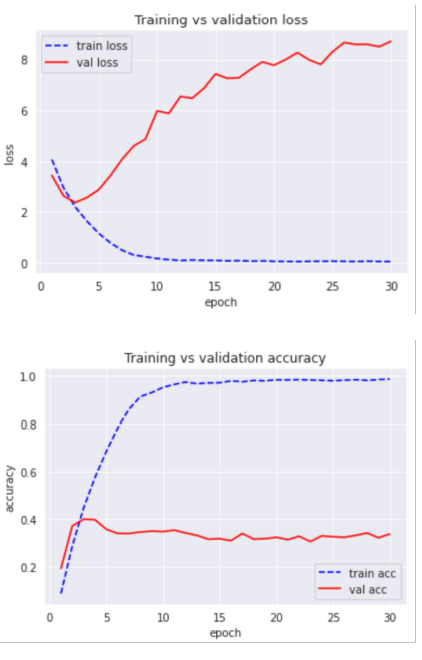

# 7. 모델 평가

### - 테스트 데이터 예측결과 평가

In [ ]:
# model evaluation
score = model.evaluate(test_generator)
print('acc = ', score[1], 'loss = ', score[0])

'''
최종 : epoch(30) batch(100) lr(0.001)/ 1층,2층(maxpool) -> strides=(2,2) 추가 
     image_size, image_sahape 150 -> 224 수정 / layer4 추가(filter:16)
학습모델: loss: 0.0389 - accuracy: 0.9894 - val_loss: 9.3787 - val_accuracy: 0.3240
실제평가: acc =  0.35600000619888306 loss =  8.449583053588867
'''

In [ ]:
### - 분류결과 평가

In [ ]:
# Test Result
test_generator = data_generator.flow_from_directory(directory= test_path,
                                                    target_size= image_size,
                                                    color_mode= 'rgb',
                                                    class_mode= 'sparse',
                                                    batch_size= 500,
                                                    shuffle= False
                                                    )
test_images, test_labels = test_generator.next()
predictions = model.predict(test_images).argmax(axis = 1)

# Map the label : Prediction
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in predictions]

# Display the result : First 5
print(f'The first 5 predictions: {pred[:5]}')

# Label of Answer
y_test = [labels[k] for k in test_labels]

# Classification Report
print(classification_report(y_test, pred))

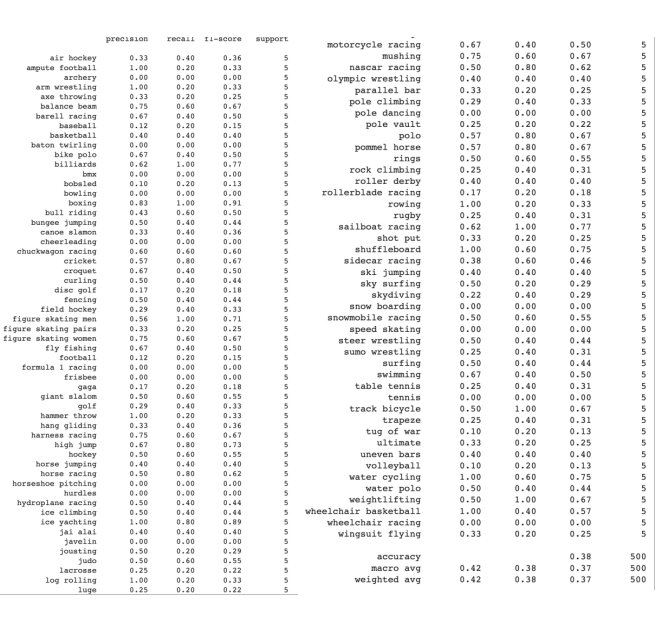

### - 혼동행렬 시각화 

In [ ]:
# Visualize Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

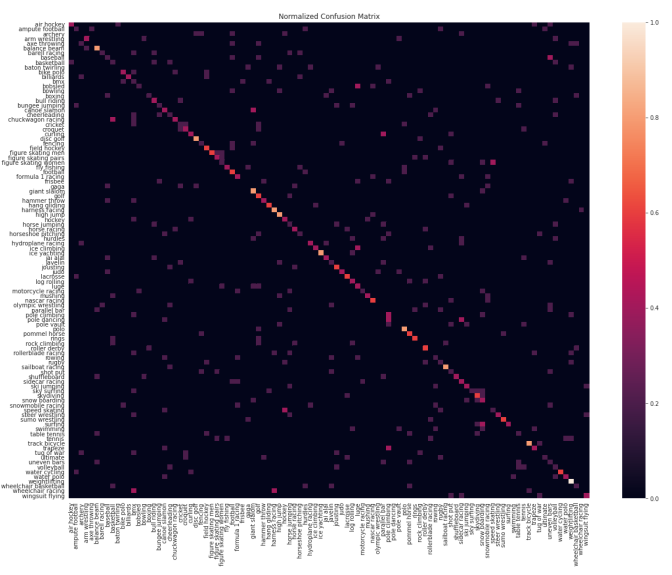

### - 오분류 이미지 시각화

In [ ]:
Filepath = test_generator.filepaths
test_df = pd.DataFrame({'Filepath':Filepath,'Label':y_test},columns=['Filepath','Label'])

# different image number
diff = []
for i in range(0,500):
  if test_df.Label.iloc[i] != pred[i]:
    diff.append(i)

# 오분류된 이미지 개수
print('오분류된 이미지 개수 :',len(diff))
# 오분류된 이미지 개수 : 308

# Example of prediction
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
diff_15 = diff[0:15] # 오분류된 이미지 15개 지정

# get 15 pictures
for ax, num in zip(axes.flat,diff_15):
  ax.imshow(plt.imread(test_df.Filepath.iloc[num]))
  ax.set_title(f"True: {test_df.Label.iloc[num]}\nPredicted: {pred[num]}")
plt.tight_layout()
plt.show()

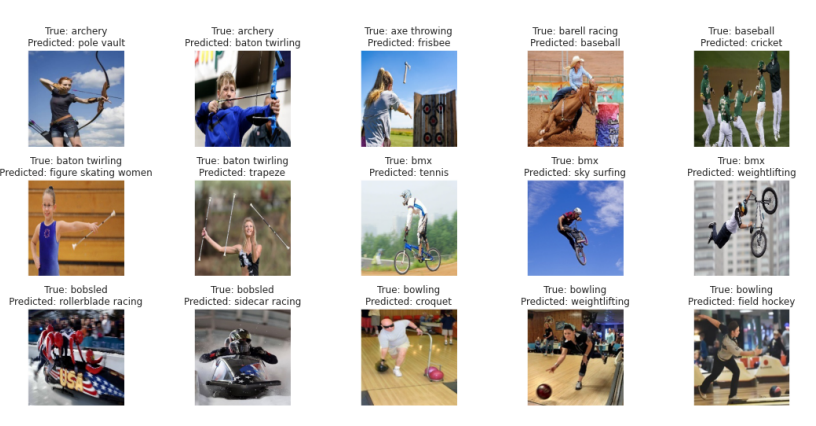